In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA
from keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

def load_kdd99():
    kdd99_df = pd.read_csv('Train_data.csv')
    X_kdd99 = kdd99_df.iloc[:, :-1]
    y_kdd99 = kdd99_df.iloc[:, -1]

    if y_kdd99.dtype == 'O':
        label_encoder = LabelEncoder()
        y_kdd99 = label_encoder.fit_transform(y_kdd99)

    categorical_features = X_kdd99.select_dtypes(include=['object']).columns
    X_kdd99 = pd.get_dummies(X_kdd99, columns=categorical_features)

    return X_kdd99.values, y_kdd99


X_kdd99, y_kdd99 = load_kdd99()


X_train_kdd99, X_test_kdd99, y_train_kdd99, y_test_kdd99 = train_test_split(X_kdd99, y_kdd99, test_size=0.2, random_state=42)


input_shape = (X_kdd99.shape[1], 1)
X_train_cnn = np.expand_dims(X_train_kdd99, axis=-1).astype('float32')
X_test_cnn = np.expand_dims(X_test_kdd99, axis=-1).astype('float32')
y_train_kdd99 = y_train_kdd99.astype('int')
y_test_kdd99 = y_test_kdd99.astype('int')
num_classes = len(np.unique(y_kdd99))


cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, kernel_size=5, activation='relu', padding='same', input_shape=input_shape))
cnn_model.add(MaxPooling1D(pool_size=2, padding='same'))
cnn_model.add(Conv1D(filters=16, kernel_size=5, activation='relu', padding='same'))
cnn_model.add(MaxPooling1D(pool_size=2, padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))


adam_optimizer = Adam(learning_rate=0.0005)
cnn_model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


cnn_model.fit(X_train_cnn, y_train_kdd99, epochs=10, batch_size=128, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])


accuracy = cnn_model.evaluate(X_test_cnn, y_test_kdd99, verbose=0)[1]
print(f'Accuracy: {accuracy:.2f}')


y_pred_probabilities = cnn_model.predict(X_test_cnn)


y_pred = np.argmax(y_pred_probabilities, axis=1)


precision = precision_score(y_test_kdd99, y_pred, average='weighted')
recall = recall_score(y_test_kdd99, y_pred, average='weighted')
f1 = f1_score(y_test_kdd99, y_pred, average='weighted')

print("Classification Report:")
print(classification_report(y_test_kdd99, y_pred))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test_kdd99, y_pred)
print(conf_matrix)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


cnn_model.save('cnn_model.h5')


Epoch 1/10
126/126 [==============================] - 2s 12ms/step - loss: 99.4854 - accuracy: 0.8546 - val_loss: 89.9056 - val_accuracy: 0.7551
Epoch 2/10
126/126 [==============================] - 1s 8ms/step - loss: 293.6319 - accuracy: 0.8835 - val_loss: 1.3498 - val_accuracy: 0.9325
Epoch 3/10
126/126 [==============================] - 1s 8ms/step - loss: 111.9365 - accuracy: 0.9001 - val_loss: 3.7151 - val_accuracy: 0.9397
Epoch 4/10
126/126 [==============================] - 1s 8ms/step - loss: 220.6299 - accuracy: 0.9120 - val_loss: 18.8176 - val_accuracy: 0.9477
Epoch 5/10
126/126 [==============================] - 1s 8ms/step - loss: 140.0658 - accuracy: 0.9313 - val_loss: 2.9584 - val_accuracy: 0.9491
Accuracy: 0.94
158/158 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2365
           1       0.93      0.96      0.94      2674

    accuracy         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical


ontology_rules = {
    "HighRisk": lambda features: features["num_failed_logins"] > 0.8 and features["dst_bytes"] < 0.2,
    "LowRisk": lambda features: features["dst_host_srv_diff_host_rate"] > 0.5,
    "SuspiciousPattern": lambda features: features["dst_bytes"] > 0.5 and features["dst_host_diff_srv_rate"] < 0.2,
    "KnownAttack": lambda features: features.get("srv_serror_rate", 0) == 1,
    "Normal": lambda features: True
}

def load_kdd99():

    kdd99_df = pd.read_csv('Train_data.csv')


    kdd99_df.fillna(0, inplace=True)

    X_kdd99 = kdd99_df.iloc[:, :-1]
    y_kdd99 = kdd99_df.iloc[:, -1]


    if y_kdd99.dtype == 'O':
        label_encoder = LabelEncoder()
        y_kdd99 = label_encoder.fit_transform(y_kdd99)

    return X_kdd99, y_kdd99

def apply_ontology_rules(features, ontology_rules):

    category = "Normal"
    if ontology_rules["KnownAttack"](features):
        category = "Attack"
    elif not ontology_rules["KnownAttack"](features):
        for rule, condition in ontology_rules.items():
            if rule != "KnownAttack" and condition(features):
                category = rule
                break
    return category


X_kdd99, y_kdd99 = load_kdd99()


attack_categories = [apply_ontology_rules(row, ontology_rules) for _, row in X_kdd99.iterrows()]


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(attack_categories)


y_encoded = to_categorical(y_encoded)


X_train, X_test, y_train, y_test = train_test_split(X_kdd99, y_encoded, test_size=0.2, random_state=42)


X_train_encoded = pd.get_dummies(X_train, columns=['protocol_type', 'service', 'flag'])
X_test_encoded = pd.get_dummies(X_test, columns=['protocol_type', 'service', 'flag'])


X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)


X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1, 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1, 1)


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 1), activation='relu', input_shape=(X_train_cnn.shape[1], 1, 1)))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Number of categories in output layer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit(X_train_cnn, y_train, epochs=5, batch_size=32, validation_split=0.1)


loss, accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


predicted_labels_encoded = model.predict(X_test_cnn)
predicted_labels = label_encoder.inverse_transform([np.argmax(label) for label in predicted_labels_encoded])


attack_counts = {}
for label in predicted_labels:
    attack_counts[label] = attack_counts.get(label, 0) + 1


for attack, count in attack_counts.items():
    print(f"Attack: {attack}, Count: {count}")

from sklearn.metrics import classification_report, confusion_matrix, precision_score


y_pred_prob = model.predict(X_test_cnn)


y_pred = np.argmax(y_pred_prob, axis=1)


y_test_labels = np.argmax(y_test, axis=1)


precision = precision_score(y_test_labels, y_pred, average='weighted')


conf_matrix = confusion_matrix(y_test_labels, y_pred)


class_report = classification_report(y_test_labels, y_pred)

print("Precision:", precision)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Epoch 1/5
567/567 [==============================] - 3s 4ms/step - loss: 0.1278 - accuracy: 0.9628 - val_loss: 0.0856 - val_accuracy: 0.9787
Epoch 2/5
567/567 [==============================] - 2s 4ms/step - loss: 0.0580 - accuracy: 0.9785 - val_loss: 0.0523 - val_accuracy: 0.9836
Epoch 3/5
567/567 [==============================] - 2s 4ms/step - loss: 0.0507 - accuracy: 0.9820 - val_loss: 0.0435 - val_accuracy: 0.9861
Epoch 4/5
567/567 [==============================] - 2s 4ms/step - loss: 0.0450 - accuracy: 0.9831 - val_loss: 0.0437 - val_accuracy: 0.9861
Epoch 5/5
158/158 [==============================] - 0s 2ms/step - loss: 0.0519 - accuracy: 0.9813
Test Loss: 0.05192282050848007, Test Accuracy: 0.981345534324646
158/158 [==============================] - 0s 2ms/step
Attack: Normal, Count: 1351
Attack: Attack, Count: 1438
Attack: SuspiciousPattern, Count: 2215
Attack: LowRisk, Count: 35
158/158 [==============================] - 0s 2ms/step
Precision: 0.981625492688707
Confusion M

In [3]:
import numpy as np
import pandas as pd
from keras.models import load_model
import os


cnn_model = load_model('cnn_model.h5')


botnet_df = pd.read_csv('botnet.csv')


botnet_df_selected = botnet_df[['Source', 'Destination', 'Protocol', 'Length']].copy()


dummy_features = ['src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
                  'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
                  'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
                  'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
                  'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
                  'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
                  'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
                  'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


for feature in dummy_features:
    botnet_df_selected[feature] = 0


X_botnet = botnet_df_selected.drop(columns=['Source', 'Destination', 'Protocol'])
X_botnet_cnn = np.expand_dims(X_botnet.values, axis=-1).astype('float32')


padded_X_botnet_cnn = np.pad(X_botnet_cnn, ((0, 0), (0, 80), (0, 0)), mode='constant')


y_pred_botnet = cnn_model.predict(padded_X_botnet_cnn)


y_pred_botnet_class = np.argmax(y_pred_botnet, axis=1)


botnet_df_selected['Prediction'] = y_pred_botnet_class


malicious_ips = botnet_df_selected[botnet_df_selected['Prediction'] == 1]['Source'].unique()


print("Malicious IP addresses detected:")
print(malicious_ips)


print("Blocking malicious IP addresses...")
for ip in malicious_ips:
    print(f"Blocking {ip}...")

    os.system(f"sudo iptables -A INPUT -s {ip} -j DROP")

print("Malicious IP addresses blocked.")


477/477 [==============================] - 1s 2ms/step
Malicious IP addresses detected:
['192.168.100.5' '192.168.100.1' '192.168.100.4' 'fe80::1' '192.168.100.9'
 '91.189.91.96']
Blocking malicious IP addresses...
Blocking 192.168.100.5...
Blocking 192.168.100.1...
Blocking 192.168.100.4...
Blocking fe80::1...
Blocking 192.168.100.9...
Blocking 91.189.91.96...
Malicious IP addresses blocked.


ERROR:pika.adapters.utils.connection_workflow:AMQPConnector - reporting failure: AMQPConnectorSocketConnectError: TimeoutError("TCP connection attempt timed out: '192.168.100.4'/(<AddressFamily.AF_INET: 2>, <SocketKind.SOCK_STREAM: 1>, 6, '', ('192.168.100.4', 5672))")
ERROR:pika.adapters.utils.connection_workflow:AMQP connection workflow failed: AMQPConnectionWorkflowFailed: 1 exceptions in all; last exception - AMQPConnectorSocketConnectError: TimeoutError("TCP connection attempt timed out: '192.168.100.4'/(<AddressFamily.AF_INET: 2>, <SocketKind.SOCK_STREAM: 1>, 6, '', ('192.168.100.4', 5672))"); first exception - None.
ERROR:pika.adapters.utils.connection_workflow:AMQPConnectionWorkflow - reporting failure: AMQPConnectionWorkflowFailed: 1 exceptions in all; last exception - AMQPConnectorSocketConnectError: TimeoutError("TCP connection attempt timed out: '192.168.100.4'/(<AddressFamily.AF_INET: 2>, <SocketKind.SOCK_STREAM: 1>, 6, '', ('192.168.100.4', 5672))"); first exception - Non

AMQPConnectionError: 

Epoch 1/10
126/126 [==============================] - 2s 10ms/step - loss: 637.5334 - accuracy: 0.8590 - val_loss: 10.0326 - val_accuracy: 0.9382
Epoch 2/10
126/126 [==============================] - 1s 8ms/step - loss: 37.7436 - accuracy: 0.9111 - val_loss: 0.8821 - val_accuracy: 0.9486
Epoch 3/10
126/126 [==============================] - 1s 8ms/step - loss: 355.4740 - accuracy: 0.9176 - val_loss: 13.0029 - val_accuracy: 0.9417
Epoch 4/10
126/126 [==============================] - 1s 8ms/step - loss: 105.0977 - accuracy: 0.9288 - val_loss: 21.9169 - val_accuracy: 0.9578
Epoch 5/10
126/126 [==============================] - 1s 9ms/step - loss: 54.1385 - accuracy: 0.9303 - val_loss: 6.1470 - val_accuracy: 0.9477
Accuracy: 0.95
158/158 [==============================] - 0s 2ms/step
    Instance Index  Actual Class  Predicted Class  Confidence
0                1             1                1    0.947109
1                2             1                1    1.000000
2                3    

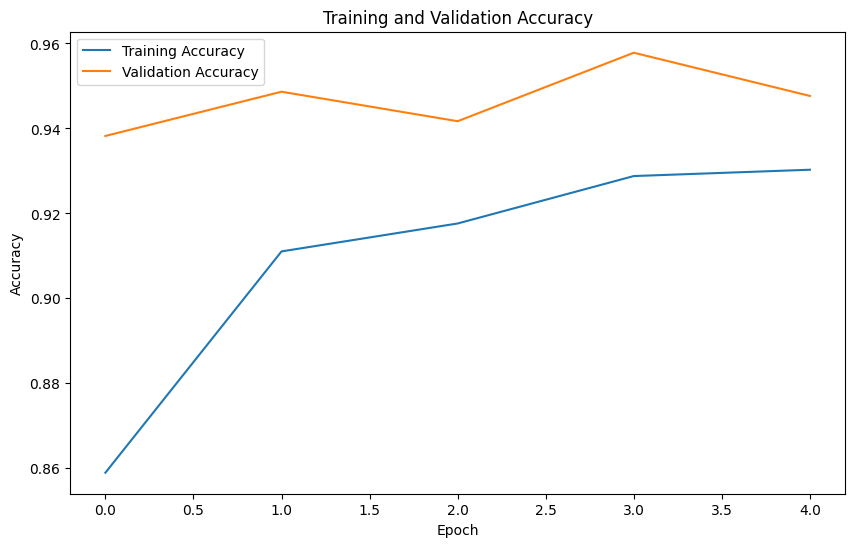

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def load_kdd99():
    kdd99_df = pd.read_csv('Train_data.csv')
    X_kdd99 = kdd99_df.iloc[:, :-1]
    y_kdd99 = kdd99_df.iloc[:, -1]

    if y_kdd99.dtype == 'O':
        label_encoder = LabelEncoder()
        y_kdd99 = label_encoder.fit_transform(y_kdd99)

    categorical_features = X_kdd99.select_dtypes(include=['object']).columns
    X_kdd99 = pd.get_dummies(X_kdd99, columns=categorical_features)

    return X_kdd99.values, y_kdd99

# Load and preprocess data
X_kdd99, y_kdd99 = load_kdd99()

# Split data
X_train_kdd99, X_test_kdd99, y_train_kdd99, y_test_kdd99 = train_test_split(X_kdd99, y_kdd99, test_size=0.2, random_state=42)

# Reshape data for CNN
input_shape = (X_kdd99.shape[1], 1)
X_train_cnn = np.expand_dims(X_train_kdd99, axis=-1).astype('float32')
X_test_cnn = np.expand_dims(X_test_kdd99, axis=-1).astype('float32')
y_train_kdd99 = y_train_kdd99.astype('int')
y_test_kdd99 = y_test_kdd99.astype('int')
num_classes = len(np.unique(y_kdd99))

# Custom CNN Model architecture
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, kernel_size=5, activation='relu', padding='same', input_shape=input_shape))
cnn_model.add(MaxPooling1D(pool_size=2, padding='same'))
cnn_model.add(Conv1D(filters=16, kernel_size=5, activation='relu', padding='same'))
cnn_model.add(MaxPooling1D(pool_size=2, padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))

# Compile the model with a customized learning rate
adam_optimizer = Adam(learning_rate=0.0005)
cnn_model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(X_train_cnn, y_train_kdd99, epochs=10, batch_size=128, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

# Evaluate the model
accuracy = cnn_model.evaluate(X_test_cnn, y_test_kdd99, verbose=0)[1]
print(f'Accuracy: {accuracy:.2f}')

# Predict probabilities for each class
y_pred_probabilities = cnn_model.predict(X_test_cnn)

# Get predicted classes
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Create a table of 50 samples
num_samples = 50
sample_indices = np.random.choice(X_test_cnn.shape[0], size=num_samples, replace=False)
sample_data = X_test_cnn[sample_indices]
sample_labels = y_test_kdd99[sample_indices]
predicted_labels = y_pred[sample_indices]
confidences = np.max(y_pred_probabilities[sample_indices], axis=1)

table = pd.DataFrame({
    "Instance Index": np.arange(1, num_samples + 1),
    "Actual Class": sample_labels,
    "Predicted Class": predicted_labels,
    "Confidence": confidences
})

print(table)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()



Epoch 1/10
126/126 [==============================] - 2s 10ms/step - loss: 300.2353 - accuracy: 0.8392 - val_loss: 31.5316 - val_accuracy: 0.9340
Epoch 2/10
126/126 [==============================] - 1s 8ms/step - loss: 158.6800 - accuracy: 0.9081 - val_loss: 169.7278 - val_accuracy: 0.7809
Epoch 3/10
126/126 [==============================] - 1s 8ms/step - loss: 158.7691 - accuracy: 0.8742 - val_loss: 48.0440 - val_accuracy: 0.9432
Epoch 4/10
126/126 [==============================] - 1s 8ms/step - loss: 113.6762 - accuracy: 0.9228 - val_loss: 8.8753 - val_accuracy: 0.9439
Epoch 5/10
126/126 [==============================] - 1s 8ms/step - loss: 992.1874 - accuracy: 0.9193 - val_loss: 77.6279 - val_accuracy: 0.9477
Epoch 6/10
126/126 [==============================] - 1s 8ms/step - loss: 69.1324 - accuracy: 0.9243 - val_loss: 4.2057 - val_accuracy: 0.9459
Epoch 7/10
126/126 [==============================] - 1s 8ms/step - loss: 45.5081 - accuracy: 0.9234 - val_loss: 13.1712 - val_accu

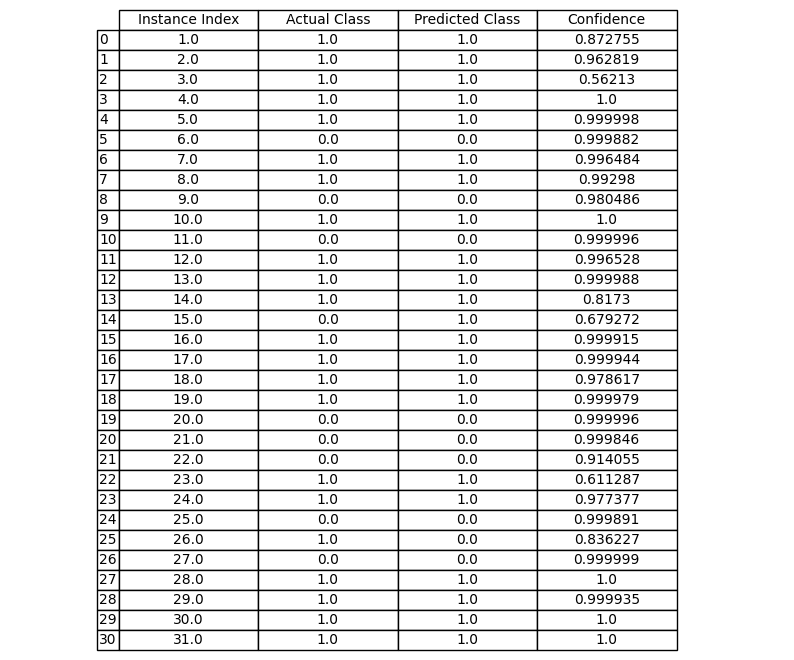